In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.notebook import trange, tqdm
import pytorch_util as ptu
from PIL import Image

ptu.set_gpu_mode(True)

#Data

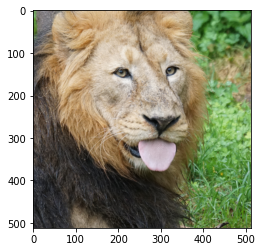

In [2]:
def load_img(fpath='lion_orig.png'):
    return cv2.imread(fpath)[:,:,[2,1,0]]  # convert BGR to RGB

im = load_img('lion_orig.png')
plt.imshow(im)

In [3]:
class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, fpath, normalize_xy=True, normalize_rgb=True):
        assert os.path.exists(fpath), "File path '{}' not found".format(fpath)
        self.fpath = fpath
        self.normalize_xy = normalize_xy
        self.normalize_rgb = normalize_rgb
        self.image = load_img(fpath).astype(np.float32)
        self.length = self.image.shape[0] * self.image.shape[1]
        assert self.image.shape[0] == self.image.shape[1]

    def __getitem__(self, index):
        i = index // self.image.shape[1]
        j = index % self.image.shape[1]
        rgb = np.copy(self.image[i, j])
        if self.normalize_rgb: 
            rgb /= 255.0
        xy = np.array([i, j]).astype(np.float32)
        if self.normalize_xy:
            xy /= self.image.shape[:2]
        return xy, rgb

    def __len__(self):
        return self.length

# Models

In [4]:
class MLP(nn.Module):
    def __init__(self, n_hidden, hidden_size, input_size, output_size, add_sigmoid=True):
        super().__init__()
        self.output_size = output_size

        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        if add_sigmoid:  
            layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: tensor of shape [batch_size, input_size]
        :return: tensor of shape [batch_size, output_size]
        """
        return self.mlp(x)

In [5]:
def plot_model(model, preprocess_fn=None, H=512, W=512, normalize_xy=True, title=None):
    img = get_memorized_image(model, preprocess_fn=preprocess_fn, H=H, W=W, normalize_xy=normalize_xy)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

def get_memorized_image(model, preprocess_fn=None, H=512, W=512, normalize_xy=True):
    img = np.zeros([H, W, 3])
    model.eval()
    with torch.no_grad():
        for h in range(H):
            x = torch.cat([torch.full([W, 1], float(h)), torch.arange(W).unsqueeze(1)], axis=1).to(ptu.device)
            if normalize_xy:
                x /= ptu.tensor([H, W])
            if preprocess_fn:
                x = preprocess_fn(x)
            img[h] = ptu.get_numpy(model(x))
    return img

def save_model_image(model, preprocess_fn, fname):
    image = get_memorized_image(model, preprocess_fn)
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    im.save(fname)

# Training

In [6]:
# need to define transformation
def apply_fourier_features(x, B):
    return torch.cat([torch.sin(2 * np.pi * torch.matmul(x, B)),
                      torch.cos(2 * np.pi * torch.matmul(x, B))], axis=1)

In [7]:
# applies gradient steps for each mini-batch in an epoch
def train(model, train_loader, optimizer, loss_fn, preprocess_fn):
    model.train()
    losses = []
    for x, y in tqdm(train_loader, desc='Batch', leave=False):
        x = preprocess_fn(x.to(ptu.device).float())
        y = y.to(ptu.device).float()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses


def eval_loss(model, data_loader, loss_fn, preprocess_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = preprocess_fn(x.to(ptu.device).float())
            y = y.to(ptu.device).float()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, loss_fn, train_args):
    # training parameters
    epochs = train_args['epochs']
    lr = train_args['lr']
    use_fourier_feature = train_args['use_fourier_features']
    sigma = train_args.get('sigma', 1.0)
    mapping_size = train_args.get('mapping_size', 256)
    plot = train_args.get('plot', False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if not use_fourier_feature:
        preprocess_fn = lambda x: x
    else:
        b_shape = (2, mapping_size)
        B = torch.normal(ptu.zeros(b_shape), 
                         torch.full(b_shape, sigma).to(ptu.device)).to(ptu.device)
        preprocess_fn = lambda x: apply_fourier_features(x, B)
    train_losses, test_losses = [], []
    if plot:
        plot_model(model, preprocess_fn=preprocess_fn, title=f'Before training')
    for epoch in trange(epochs, desc='Epoch', leave=False):
        model.train()
        train_loss_lst = train(model, train_loader, optimizer, loss_fn, preprocess_fn)
        train_loss = np.mean(train_loss_lst)
        train_losses.append(train_loss)
        if test_loader:
            test_losses.append(eval_loss(model, test_loader, loss_fn, preprocess_fn))

        if plot:
            plot_model(model, preprocess_fn=preprocess_fn, title=f'Epoch {epoch}')
    if plot:
        plot_model(model, preprocess_fn=preprocess_fn, title='Final model')
    return train_losses, test_losses, preprocess_fn

# Results

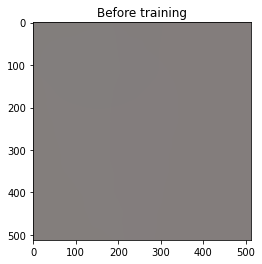

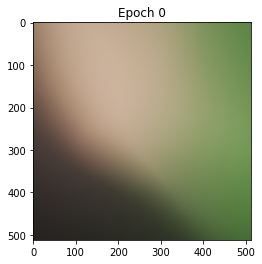

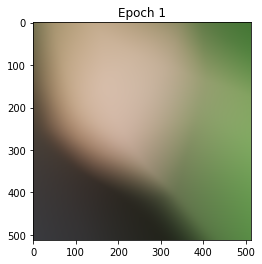

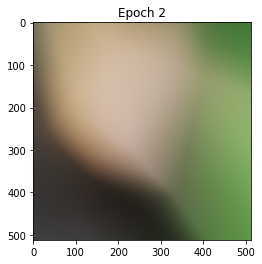

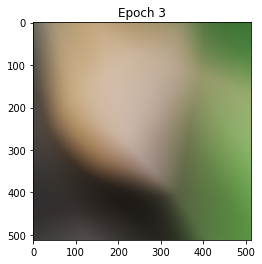

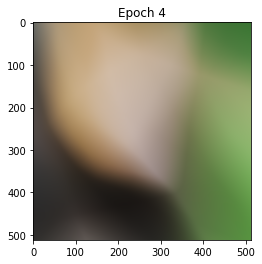

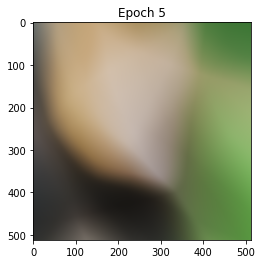

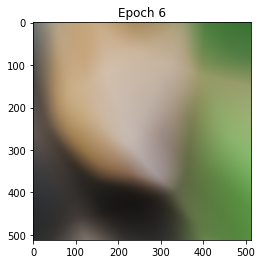

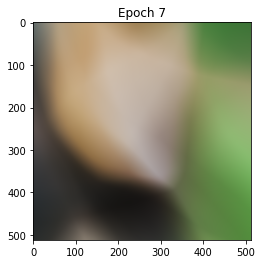

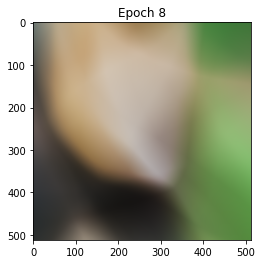

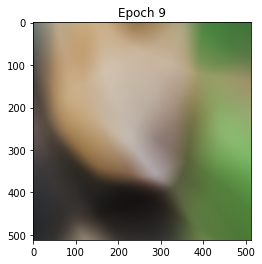

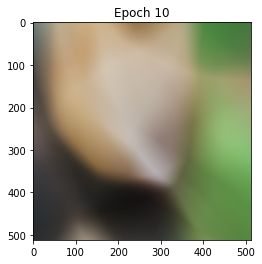

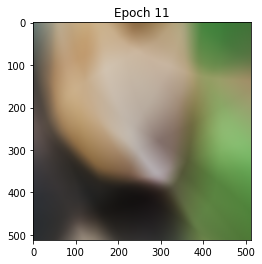

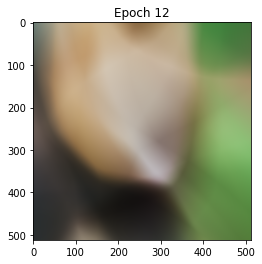

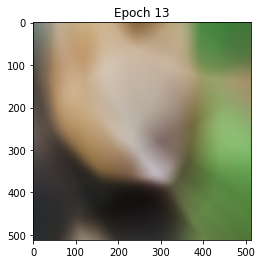

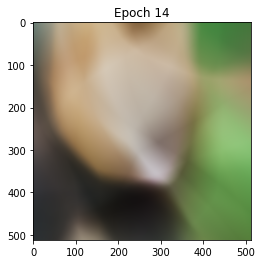

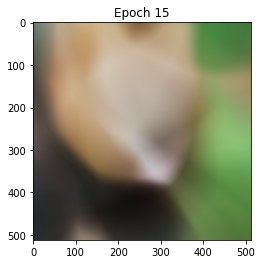

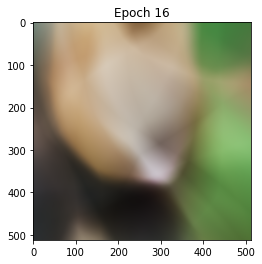

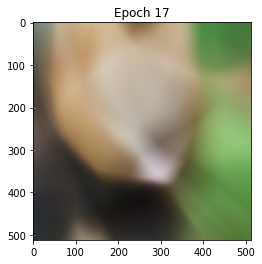

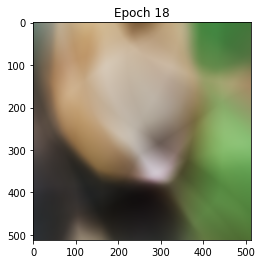

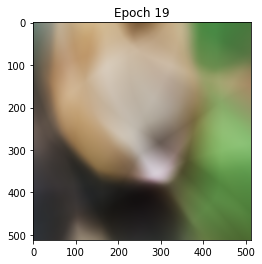

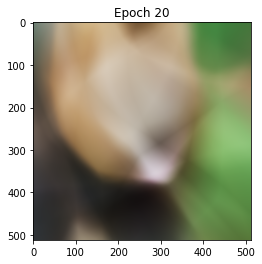

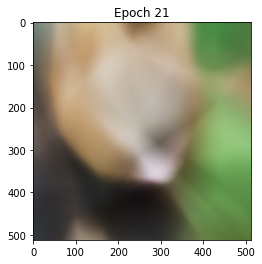

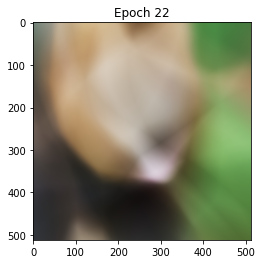

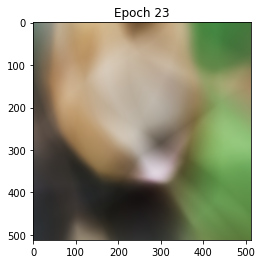

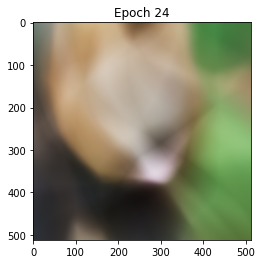

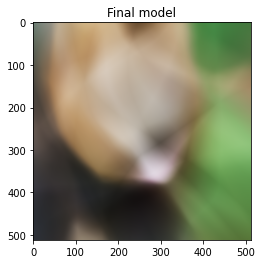

In [ ]:
train_args = dict(
    epochs=25,
    lr=1e-4,
    use_fourier_features=False,
    plot=True)
model = MLP(4, 256, 2, 3).to(ptu.device)
dataset = torch.utils.data.DataLoader(SingleImageDataset('lion_orig.png'), batch_size=1024, shuffle=True)
mlp_train_losses, mlp_test_losses, mlp_preprocess = train_epochs(model, dataset, None, F.mse_loss, train_args)
save_model_image(model, mlp_preprocess, 'mlp_lion.png')

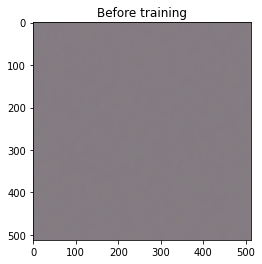

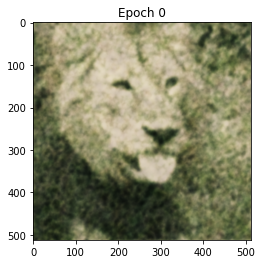

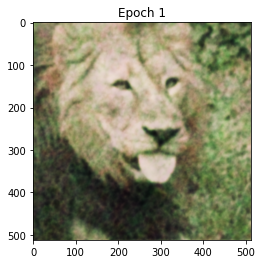

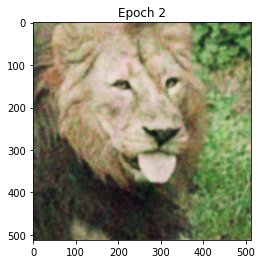

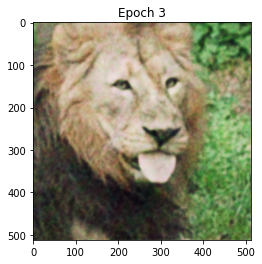

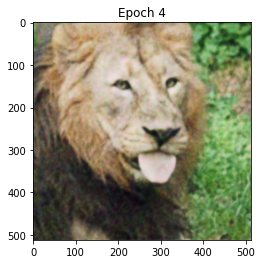

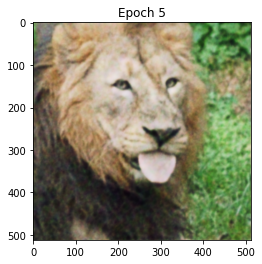

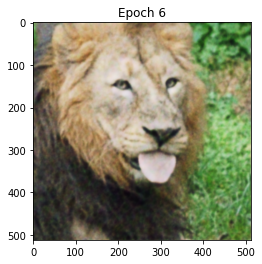

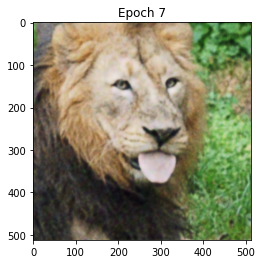

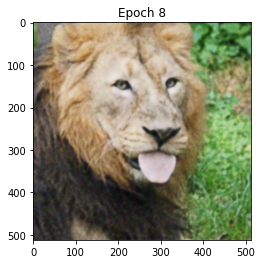

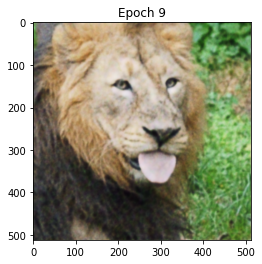

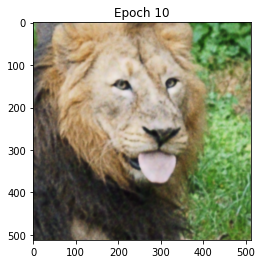

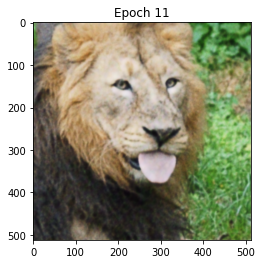

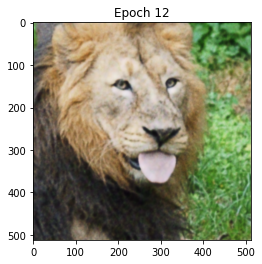

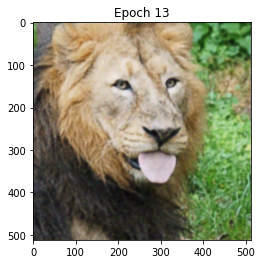

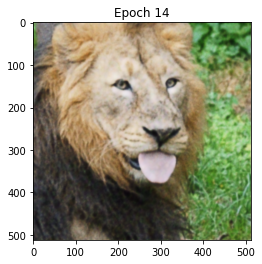

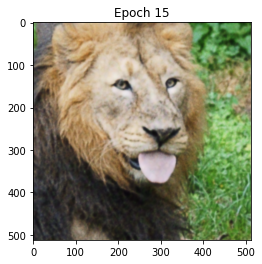

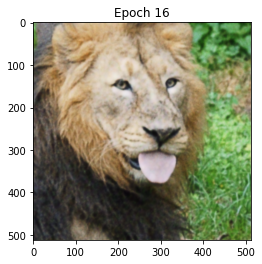

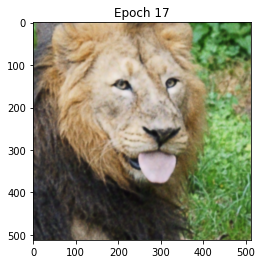

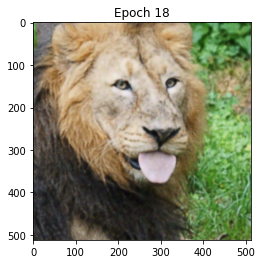

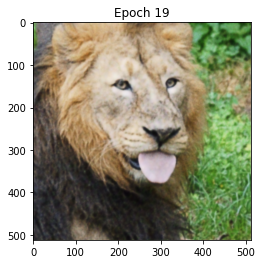

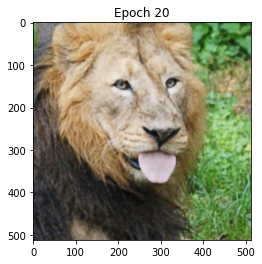

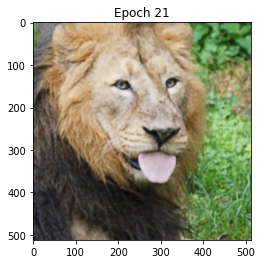

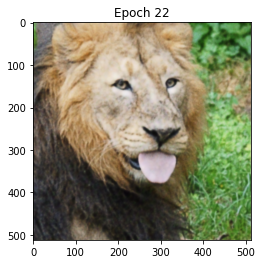

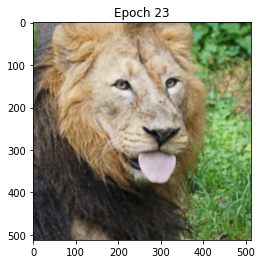

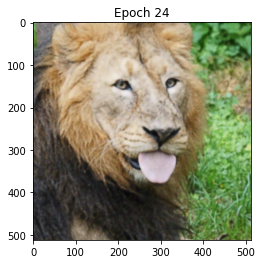

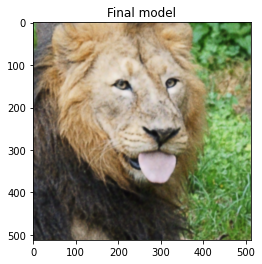

In [8]:
train_args = dict(
    epochs=25,
    lr=1e-4,
    use_fourier_features=True,
    sigma=10.0,
    mapping_size=128,
    plot=True)
model = MLP(4, 256, 256, 3).to(ptu.device)
dataset = torch.utils.data.DataLoader(SingleImageDataset('lion_orig.png'), batch_size=1024, shuffle=True)
ff_train_losses, ff_test_losses, ff_preprocess = train_epochs(model, dataset, None, F.mse_loss, train_args)
save_model_image(model, ff_preprocess, 'ff_lion.png')

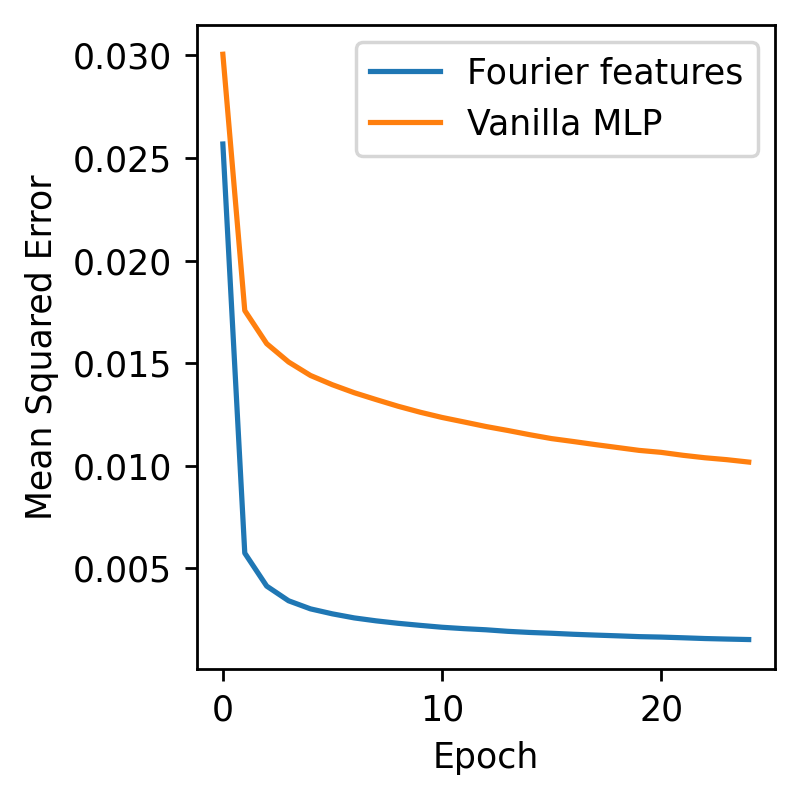

In [ ]:
# plot the losses
plt.figure(dpi=250, figsize=(3, 3))
plt.plot(np.arange(len(ff_train_losses)), ff_train_losses, label='Fourier features')
plt.plot(np.arange(len(mlp_train_losses)), mlp_train_losses, label='Vanilla MLP')
plt.legend()
# plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
# plt.title('Train Loss')
plt.tight_layout(pad=0)
plt.savefig('fig1_loss.pdf')